# Classification of Films based on Domestic Gross

By Vignesh Chilecampali, Georgina Garza, Claire McAfee, Jacob Zillifro

This data mining exploration is an attempt to create a model to predict if a film will earn $163 million domestically.

## Setup

Import necessary tools/libraries and login to Darwin SDK.

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import numpy as np
import json
import csv
from sklearn.metrics import classification_report
import matplotlib.colors as colo
import sklearn as sk
import sklearn.cluster as clstr
import array

from amb_sdk.sdk import DarwinSdk

In [2]:
# Login
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('claire.mcafee@gmail.com', 'Fhze5hUMn3')

if not status:
    print(msg)

## Bring in Data

Convert datasets to csv files, bring them in and put them in dataframes.

In [3]:
# Code to convert new dataset file from json to csv

# path = 'datasets/'
# file = open('datasets/film_imdb.json')
# film_data = json.load(file)

# output = csv.writer(open("datasets/film_data.csv", "w"))
# output.writerow(film_data[0].keys())
# for item in film_data:
#     output.writerow(item.values())

In [4]:
# Bring in datasets from various sources
path = 'datasets/'

dataset1_name = 'MovieBudgetsAndBoxOfficeEarnings.csv'
df1 = pd.read_csv(os.path.join(path, dataset1_name))

dataset2_name = 'IMDBMovieDatabase.csv'
df2 = pd.read_csv(os.path.join(path, dataset2_name))

dataset3_name = 'BechdelTest.csv'
df3 = pd.read_csv(os.path.join(path, dataset3_name))

dataset4_name = 'film_data.csv'
df4 = pd.read_csv(os.path.join(path, dataset4_name), error_bad_lines=False, warn_bad_lines=False)

## Data Prep

Clean data and drop conflicting columns.

In [5]:
# Method to fix titles to be named uniformly
# If the word 'The' or 'A' is the first word of the title, but is currently at the end,
# flip it so it is at the beginning
def title_fix(title):
    if title[-5:] == ", The":
        return "The " + title[:-5]
    elif title[-3:] == ", A":
        return "A " + title[:-3]
    return title

In [6]:
# Fix titles to be uniform
df1['title'] = df1['title'].apply(title_fix)
df2['title'] = df2['title'].apply(title_fix)

# Two separate datasets contain this column, so delete this instance
df2 = df2.drop(['budget'], axis=1)

# Only pull in title & bechdel score from third dataset
df3 = df3[["title", "binary"]].copy()
df3.rename(index=str, inplace = True, columns={"binary": "bechdel"})

# Rename 'Title' to 'title' for merging purposes
df4.rename(index=str, inplace = True, columns={"Title": "title"})

## Combine Datasets

Pull all our sources of data together into initial state of dataframe.

In [7]:
# Merge datasets
df = df1.merge(df2, on=['title', 'year'])
df = df.merge(df3, on='title', how='left')
df = df.merge(df4, on='title')
df.head()

,title,Month,Day,year,Budget($M),Domestic Gross($M),Worldwide Gross($M),var1,length,rating,...,Language,Country,Awards,Poster,Metascore,imdbRating,imdbVotes,imdbID,Type,Response
0,Titanic,Dec,19,1997,200.0,659.363944,2208.208395,52348,194,6.9,...,English,USA,Won 11 Oscars. Another 110 wins & 73 nominations.,https://images-na.ssl-images-amazon.com/images...,74.0,7.7,"806,925",tt0120338,movie,True
1,Titanic,Dec,19,1997,200.0,659.363944,2208.208395,52348,194,6.9,...,English,USA,Won 11 Oscars. Another 110 wins & 73 nominations.,https://images-na.ssl-images-amazon.com/images...,74.0,7.7,"806,925",tt0120338,movie,True
2,Titanic,Dec,19,1997,200.0,659.363944,2208.208395,52348,194,6.9,...,English,USA,Won 11 Oscars. Another 110 wins & 73 nominations.,https://images-na.ssl-images-amazon.com/images...,74.0,7.7,"806,925",tt0120338,movie,True
3,Titanic,Dec,19,1997,200.0,659.363944,2208.208395,52348,194,6.9,...,English,USA,Won 11 Oscars. Another 110 wins & 73 nominations.,https://images-na.ssl-images-amazon.com/images...,74.0,7.7,"806,925",tt0120338,movie,True
4,Titanic,Dec,19,1997,200.0,659.363944,2208.208395,52348,194,6.9,...,English,USA,Won 11 Oscars. Another 110 wins & 73 nominations.,https://images-na.ssl-images-amazon.com/images...,74.0,7.7,"806,925",tt0120338,movie,True


## Data Exploration

Explore data to search for possible patterns, clusters, and distributions.

These are the films binned into ranges of domestic income:
(-0.659, 26.375]      1308
(26.375, 52.749]       632
(52.749, 79.124]       372
(79.124, 105.498]      187
(105.498, 131.873]     134
(131.873, 158.247]      83
(158.247, 184.622]      78
(210.996, 237.371]      34
(184.622, 210.996]      24
(237.371, 263.746]      21
(290.12, 316.495]        8
(316.495, 342.869]       8
(263.746, 290.12]        7
(395.618, 421.993]       7
(369.244, 395.618]       6
(632.989, 659.364]       5
(421.993, 448.367]       2
(606.615, 632.989]       0
(342.869, 369.244]       0
(448.367, 474.742]       0
(474.742, 501.117]       0
(501.117, 527.491]       0
(527.491, 553.866]       0
(553.866, 580.24]        0
(580.24, 606.615]        0
Name: Domestic Gross($M), dtype: int64


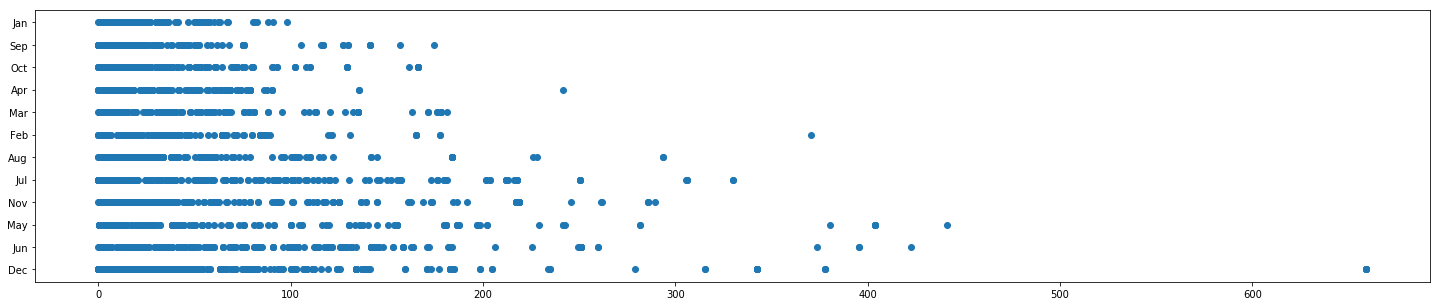

In [8]:
# Split into bins
bins = pd.cut(df['Domestic Gross($M)'], bins=25).value_counts()
print("These are the films binned into ranges of domestic income:")
print(bins)

# Show range of domestic gross
# Compared to arbitrary feature
plt.figure(figsize=(25,5))
plt.scatter(x=df['Domestic Gross($M)'], y=df['Month'])

In [9]:
# Look for natural bisecting clusters within data
df['arbitrary'] = 1
nd = df[['arbitrary', 'Domestic Gross($M)']].copy()
km = sk.cluster.KMeans(n_clusters=2)
km.fit(nd)
km.labels_
# ******************************LETS SHOW THIS SOMEHOW???**************************
# ******************************LETS SHOW THIS SOMEHOW???**************************
# ******************************LETS SHOW THIS SOMEHOW???**************************
# ******************************LETS SHOW THIS SOMEHOW???**************************
# ******************************LETS SHOW THIS SOMEHOW???**************************
# ******************************LETS SHOW THIS SOMEHOW???**************************
# This is where we find 163 to be the ideal value for our threshold for classification purposes
km.predict([[1,163]])

# Drop feature created for exploration
df.drop('arbitrary', axis=1)

# Why is this here? What does it do?******************************************************************************
df.dropna()

,title,Month,Day,year,Budget($M),Domestic Gross($M),Worldwide Gross($M),var1,length,rating,...,Country,Awards,Poster,Metascore,imdbRating,imdbVotes,imdbID,Type,Response,arbitrary
0,Titanic,Dec,19,1997,200.000,659.363944,2208.208395,52348,194,6.9,...,USA,Won 11 Oscars. Another 110 wins & 73 nominations.,https://images-na.ssl-images-amazon.com/images...,74.0,7.7,"806,925",tt0120338,movie,True,1
1,Titanic,Dec,19,1997,200.000,659.363944,2208.208395,52348,194,6.9,...,USA,Won 11 Oscars. Another 110 wins & 73 nominations.,https://images-na.ssl-images-amazon.com/images...,74.0,7.7,"806,925",tt0120338,movie,True,1
2,Titanic,Dec,19,1997,200.000,659.363944,2208.208395,52348,194,6.9,...,USA,Won 11 Oscars. Another 110 wins & 73 nominations.,https://images-na.ssl-images-amazon.com/images...,74.0,7.7,"806,925",tt0120338,movie,True,1
3,Titanic,Dec,19,1997,200.000,659.363944,2208.208395,52348,194,6.9,...,USA,Won 11 Oscars. Another 110 wins & 73 nominations.,https://images-na.ssl-images-amazon.com/images...,74.0,7.7,"806,925",tt0120338,movie,True,1
4,Titanic,Dec,19,1997,200.000,659.363944,2208.208395,52348,194,6.9,...,USA,Won 11 Oscars. Another 110 wins & 73 nominations.,https://images-na.ssl-images-amazon.com/images...,74.0,7.7,"806,925",tt0120338,movie,True,1
5,The Lord of the Rings: The Return of the King,Dec,17,2003,94.000,377.845905,1141.403341,30659,251,9.0,...,"USA, New Zealand",Won 11 Oscars. Another 174 wins & 113 nominati...,https://images-na.ssl-images-amazon.com/images...,94.0,8.9,"1,238,528",tt0167260,movie,True,1
6,The Lord of the Rings: The Return of the King,Dec,17,2003,94.000,377.845905,1141.403341,30659,251,9.0,...,"USA, New Zealand",Won 11 Oscars. Another 174 wins & 113 nominati...,https://images-na.ssl-images-amazon.com/images...,94.0,8.9,"1,238,528",tt0167260,movie,True,1
7,The Lord of the Rings: The Return of the King,Dec,17,2003,94.000,377.845905,1141.403341,30659,251,9.0,...,"USA, New Zealand",Won 11 Oscars. Another 174 wins & 113 nominati...,https://images-na.ssl-images-amazon.com/images...,94.0,8.9,"1,238,528",tt0167260,movie,True,1
11,Shrek 2,May,19,2004,70.000,441.226247,937.008132,46649,92,7.8,...,USA,Nominated for 2 Oscars. Another 16 wins & 48 n...,https://images-na.ssl-images-amazon.com/images...,75.0,7.2,"318,647",tt0298148,movie,True,1
13,The Lord of the Rings: The Two Towers,Dec,18,2002,94.000,342.548984,934.699645,30660,223,8.8,...,"USA, New Zealand",Won 2 Oscars. Another 114 wins & 127 nominations.,https://images-na.ssl-images-amazon.com/images...,88.0,8.7,"1,120,701",tt0167261,movie,True,1


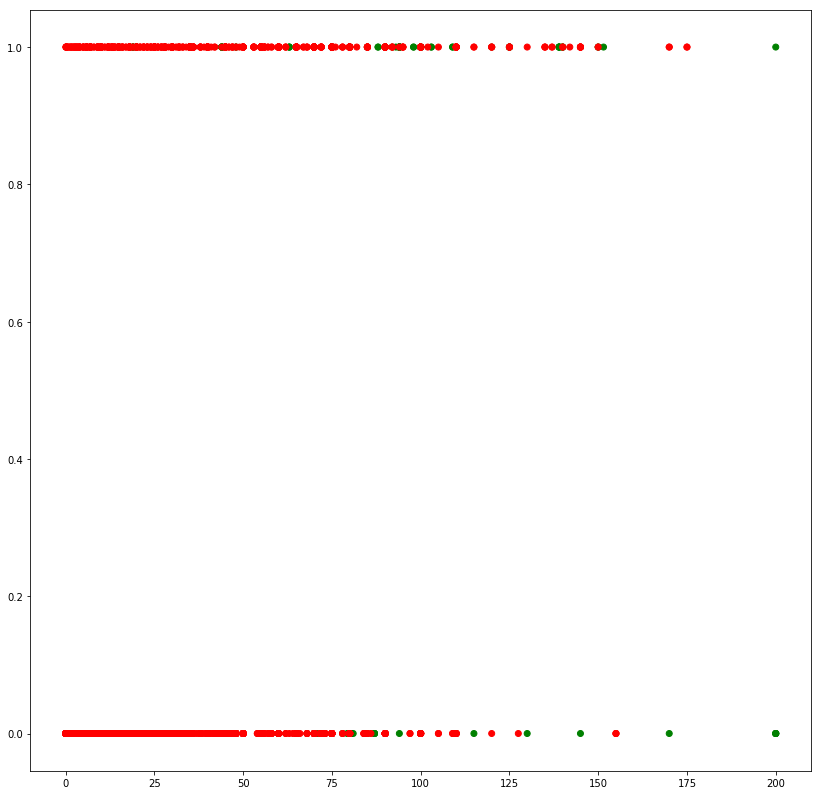

In [10]:
# Set threshold based on data exploration
df['label'] = df['Domestic Gross($M)'].apply(lambda x: 1 if x >= 163 else 0)

# Show spread of domestic gross compared to budget and arbitrary feature
plt.figure(figsize=(14,14))
plt.scatter(x=df['Budget($M)'], y=df['Action'], c=df['label'], cmap=colo.ListedColormap(['red', 'green']))
plt.show()

# We discover that movies with larger budgets tend to make more domestic gross

In [11]:
# Attempts to drop non-English films

# df['language'].value_counts()

# imdb_films = imdb_films[imdb_films.Language != 'English']

# indices = df[df.Language == 'English'].index
# df4.drop(indices, inplace=True)

# df = df[df.Language != 'English']
# print(imdb_films)

## Feature Engineering

Create new features based on pre-existing ones and drop irrelavant features.

In [12]:
# Drop unnecessary columns
drop_list = ['Day','var1', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 
             'Plot', 'Type', 'Poster', 'Response', 'Year', 'Rated', 'Released', 'Runtime', 
             'Language', 'Country', 'Awards', 'imdbRating', 'imdbVotes', 'imdbID', 'arbitrary']

df = df.drop(drop_list, axis=1)
df.drop_duplicates(inplace=True)

In [13]:
# Rename columns to be uniform
rename_dict = {"Month": "month", "Budget($M)": "budget", "Action": "action", "Animation": "animation", 
               "Comedy": "comedy", "Drama": "drama", "Documentary": "documentary", "Romance": "romance", 
               "Short": "short", "Genre": "genre", "Director": "director", "Writer": "writer", "Actors":"actors",
              "Metascore": "metascore"}

df.rename(index=str, inplace = True, columns=rename_dict)

Total incomes for actors, directors, and writers in order to have new numerical features.

In [14]:
# Dictionary to hold a cache of each actor's total income
actorsIncome = {}

# Go through each film in dataset to total each actor's income
for index, row in df.iterrows():
    currActors = row['actors']
    
    # Type check to ensure not nan value
    if type(currActors) is str:
        # Split actors into list
        actorsList = currActors.split(", ")
        income = row['Domestic Gross($M)']
        # If already in cache, update, otherwise intialize
        for actor in actorsList:
            if actor in actorsIncome:
                actorsIncome[actor] += income
            else:
                actorsIncome[actor] = income

# For a film, get the total income of all the actors
# Paramaters: list of actors, income for specified movie
def getActorTotal(actorsList, income):
    result = 0
    for actor in actorsList:
        currIncome = actorsIncome[actor]
        # Remove the income from this specific movie
        result += currIncome - income
    return result  

# Return gross of all actors in this film
def actorgross(row):
    currActors = row['actors']
    # Type check to ensure not nan value
    if type(currActors) is str:
        # Split actors into list
        actorsList = currActors.split(", ")
        actorTotal = getActorTotal(actorsList, income)
        return actorTotal
    return 0

In [15]:
# Dictionary to hold a cache of each director's total income
directorsIncome = {}

# Go through each film in dataset to total each director's income
for index, row in df.iterrows():
    currDirectors = row['director']
    
    # Type check to ensure not nan value
    if type(currDirectors) is str:
        # Split directors into list
        directorList = currDirectors.split(", ")
        income = row['Domestic Gross($M)']
        # If already in cache, update, otherwise intialize
        for director in directorList:
            if director in directorsIncome:
                directorsIncome[director] += income
            else:
                directorsIncome[director] = income                

# For a film, get the total income of all the directors
# Paramaters: list of directors, income for specified movie                
def getDirectorTotal(directorList, income):
    result = 0
    for director in directorList:
        currIncome = directorsIncome[director]
        # Remove the income from this specific movie
        result += currIncome - income
    return result 

# Return gross of all directors in this film
def directorgross(row):
        currDirectors = row['director']
        # Type check to ensure not nan value
        if type(currDirectors) is str:
            # Split directors into list
            directorList = currDirectors.split(", ")
            directorTotal = getDirectorTotal(directorList, income)
            return directorTotal
        return 0

In [16]:
# Dictionary to hold a cache of each writer's total income
writersIncome = {}

# Go through each film in dataset to total each writer's income
for index, row in df.iterrows():
    currWriters = row['writer']
    
    # Type check to ensure not nan value
    if type(currWriters) is str:
        # Split writers into list
        writerList = currWriters.split(", ")
        updatedList = []
        # Remove duplicates of writers who had multiple roles
        for writer in writerList:
            split = writer.split(" (")
            if split[0] not in updatedList:
                updatedList.append(split[0])        
        income = row['Domestic Gross($M)']
        # If already in cache, update, otherwise intialize
        for writer in updatedList:
            if writer in writersIncome:
                writersIncome[writer] += income
            else:
                writersIncome[writer] = income  

# For a film, get the total income of all the writers
# Paramaters: list of writers, income for specified movie                  
def getWriterTotal(writerList, income):
    result = 0
    updatedList = []
    # Remove duplicates of writers who had multiple roles
    for writer in writerList:
        split = writer.split(" (")
        if split[0] not in updatedList:
            updatedList.append(split[0])   
    for writer in updatedList:
        currIncome = writersIncome[writer]
        # Remove the income from this specific movie
        result += currIncome - income
    return result 


# Return gross of all writers in this film
def writergross(row):
        currWriters = row['writer']
        # Type check to ensure not nan value
        if type(currWriters) is str:
            # Split writers into list
            writerList = currWriters.split(", ")
            writerTotal = getWriterTotal(writerList, income)
            return writerTotal
        return 0

In [17]:
# Create new features based on total gross information for actors, directors, and writers
df['actor gross'] = df.apply(lambda row: actorgross(row), axis=1)
df['director gross'] = df.apply(lambda row: directorgross(row), axis=1)
df['writer gross'] = df.apply(lambda row: writergross(row), axis=1)

# Drop old columns that are now irrelevant
df = df.drop(['actors', 'director', 'writer'], axis=1) 

Create feature for classification label

In [18]:
# Set threshold based on data exploration
df['label'] = df['Domestic Gross($M)'].apply(lambda x: 1 if x >= 163 else 0)

df = df.drop(['Domestic Gross($M)', 'Worldwide Gross($M)'], axis=1) 

print("Final Features for dataset:")
print(df.keys())
df.head()

Final Features for dataset:
Index(['title', 'month', 'year', 'budget', 'length', 'rating', 'votes', 'mpaa',
       'action', 'animation', 'comedy', 'drama', 'documentary', 'romance',
       'short', 'bechdel', 'genre', 'metascore', 'label', 'actor gross',
       'director gross', 'writer gross'],
      dtype='object')


,title,month,year,budget,length,rating,votes,mpaa,action,animation,...,documentary,romance,short,bechdel,genre,metascore,label,actor gross,director gross,writer gross
0,Titanic,Dec,1997,200.0,194,6.9,90195,PG-13,0,0,...,0,1,0,PASS,"Drama, Romance",74.0,1,3458.490229,1186.532864,1487.306592
5,The Lord of the Rings: The Return of the King,Dec,2003,94.0,251,9.0,103631,PG-13,1,0,...,0,0,0,FAIL,"Adventure, Drama, Fantasy",94.0,1,2632.327620,1101.600170,4337.694063
8,Jurassic Park,Jun,1993,63.0,127,7.4,57473,NaN,1,0,...,0,0,0,PASS,"Adventure, Sci-Fi, Thriller",68.0,1,2690.839177,2499.266672,2752.021457
10,The Lion King,Jun,1994,79.3,89,7.8,32924,NaN,0,1,...,0,0,0,FAIL,"Animation, Adventure, Drama",83.0,1,2170.678673,1126.350304,19424.401030
11,Shrek 2,May,2004,70.0,92,7.8,27236,PG,0,1,...,0,0,0,PASS,"Animation, Adventure, Comedy",75.0,1,5306.928826,1396.894051,6717.523333


## Darwin SDK

Calls to Darwin SDK to upload dataset, create model, and test predictions.

In [19]:
# Put dataframe into a csv file
resulting_csv = "result_data.csv"
df.to_csv((path + resulting_csv), index=False)

In [20]:
# Upload dataset
# Delete old dataset to properly update to new one
ds.delete_dataset(resulting_csv)

status, dataset = ds.upload_dataset(os.path.join(path, resulting_csv))
if not status:
    print(dataset)

In [21]:
# Clean dataset
target = "label"
status, job_id = ds.clean_data(resulting_csv, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-11T19:24:05.869704', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['result_data.csv'], 'artifact_names': ['9a8e4d1180094596a87e577d27ce88bf'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-11T19:24:05.869704', 'endtime': '2019-04-11T19:24:09.368172', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['result_data.csv'], 'artifact_names': ['9a8e4d1180094596a87e577d27ce88bf'], 'model_name': None, 'job_error': ''}


In [22]:
# Delete old model to properly update to new one
ds.delete_model(target+"_model")

# Create model
model = target + "_model"
status, job_id = ds.create_model(dataset_names = resulting_csv, \
                                 model_name =  model, \
                                 max_train_time = '00:02')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-11T19:24:23.174294', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['result_data.csv'], 'artifact_names': None, 'model_name': 'label_model', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-11T19:24:23.174294', 'endtime': None, 'percent_complete': 3, 'job_type': 'TrainModel', 'loss': 0.3532097339630127, 'generations': 2, 'dataset_names': ['result_data.csv'], 'artifact_names': None, 'model_name': 'label_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-11T19:24:23.174294', 'endtime': None, 'percent_complete': 3, 'job_type': 'TrainModel', 'loss': 0.3532097339630127, 'generations': 2, 'dataset_names': ['result_data.csv'], 'artifact_names': None, 'model_name': 'label_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-11T19:24:23.174294', 'endtime': None, 'percent_complete': 3, 'job_type': 'TrainModel', 'loss': 0.35320973396301

In [23]:
# Train model more
status, job_id = ds.resume_training_model(dataset_names = resulting_csv,
                                          model_name = model,
                                          max_train_time = '00:05')
                                          
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-11T19:26:40.049111', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.05992405582219362, 'generations': 3, 'dataset_names': ['result_data.csv'], 'artifact_names': None, 'model_name': 'label_model', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-11T19:26:40.049111', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.05992405582219362, 'generations': 5, 'dataset_names': ['result_data.csv'], 'artifact_names': None, 'model_name': 'label_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-11T19:26:40.049111', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.05992405582219362, 'generations': 5, 'dataset_names': ['result_data.csv'], 'artifact_names': None, 'model_name': 'label_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-11T19:26:40.049111', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'lo

In [24]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-11T19:28:41.746905', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.06531072966754436, 'generations': 8, 'dataset_names': None, 'artifact_names': ['f2cd0ccc1ca441309f555029a1900cc8'], 'model_name': 'label_model', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-11T19:28:41.746905', 'endtime': '2019-04-11T19:28:50.33712', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.06531072966754436, 'generations': 8, 'dataset_names': None, 'artifact_names': ['f2cd0ccc1ca441309f555029a1900cc8'], 'model_name': 'label_model', 'job_error': ''}


In [25]:
# Show all features and their importance in training the model
feature_importance[0:]

votes              0.211221
director gross     0.142953
actor gross        0.141934
writer gross       0.115633
budget             0.081294
rating             0.049978
metascore          0.042146
length             0.033436
year               0.031694
mpaa = PG-13       0.027630
bechdel = PASS     0.019193
mpaa = R           0.017409
month = May        0.015246
animation = 1      0.013041
action = 1         0.011652
drama = 1          0.007650
month = Nov        0.007106
comedy = 1         0.004861
month = Mar        0.004636
month = Jul        0.004596
month = Jun        0.004305
mpaa = PG          0.003616
romance = 1        0.003234
month = Oct        0.002261
month = Dec        0.002204
month = Feb        0.000705
month = Aug        0.000367
documentary = 1    0.000000
short              0.000000
month = Jan        0.000000
month = Sep        0.000000
dtype: float64

In [26]:
# Run the model
status, artifact = ds.run_model(resulting_csv, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Complete', 'starttime': '2019-04-11T19:28:59.360699', 'endtime': '2019-04-11T19:29:00.427814', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.06531072966754436, 'generations': 8, 'dataset_names': ['result_data.csv'], 'artifact_names': ['c8e559616a5e4244ab749986ee04ad06'], 'model_name': 'label_model', 'job_error': ''}


(True, 'Job completed')

In [27]:
# Make predictions for dataset
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,label,prob_0,prob_1
0,1,0.029461,0.970539
1,1,0.027215,0.972785
2,1,0.062789,0.937211
3,1,0.017367,0.982633
4,1,0.016234,0.983766


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1720
           1       0.85      0.67      0.75        89

   micro avg       0.98      0.98      0.98      1809
   macro avg       0.91      0.83      0.87      1809
weighted avg       0.98      0.98      0.98      1809



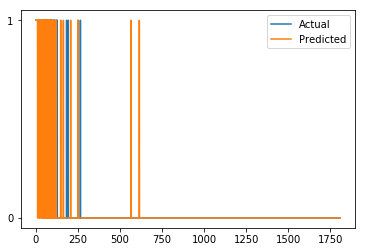

In [28]:
# Show evaluations of predictions
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

In [29]:
# Print model used by Darwin SDK
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

[{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 33}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'hardtanh', 'numunits': 47}}}, {'layer 3': {'type': 'LinearGene', 'parameters': {'activation': 'leakyrelu', 'numunits': 33}}}, {'layer 4': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 52}}}, {'layer 5': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 2}}}]
